In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import signal
import scipy
import pandas as pd
# from helper import open_dat_file

import struct

if "base_folder" not in locals():
    base_folder = "./"

import sys
sys.path.append(base_folder)
sys.path.append(base_folder+"src/")

from sar import *

# # Configure plot universal property
plt.rcParams['figure.figsize'] = (16, 16)
plt.rcParams['font.size'] = 16

import seaborn as sns;

%matplotlib inline

In [2]:
import glob
import scipy.io as sio
import load_binary as load


def stat(array):
    print(array.min(), array.mean(), array.max())
    

data_folder = base_folder + "./data/ex4/victor_dataset/"

rla_frame = load.floats_from_file_with_size_swap_endian(data_folder +"i_1206_" + "rla" + ".dat") 
rla_frame = rla_frame[:-15,:-3]
stat(rla_frame)
print(rla_frame.shape)

fscale = np.sin(rla_frame)*1e-6
fscl = np.sqrt(np.sin(rla_frame)*1e-6)


data_files = glob.glob(base_folder + './data/ex4/*.dat')
data_files = np.sort(data_files)

n_window = 5
mean_filter = np.ones((n_window, n_window))/n_window
mean_filter /=sum(mean_filter)



c = 1 / 10000

dfs = {}
for idx, f in enumerate(data_files, 1):         
    print(idx, f)
    temp = load.complexs_from_file_with_size_swap_endian(f)
    #temp[ temp == 0 ] = sys.float_info.epsilon
    # temp = scipy.signal.fftconvolve(temp, mean_filter, mode='same')
    # print('Data min:', np.abs(temp.min()),'Data mean:', np.abs(temp.mean()), 'Data max:', np.abs(temp.max()))
    print('Data min:', np.abs(temp).min(),'\tData mean:', np.abs(temp).mean(), '\tData max:', np.abs(temp).max())
    # print('Data min:', image_dB(np.abs(temp)).min(),'\tData mean:', image_dB(np.abs(temp)).mean(), '\tData max:', image_dB(np.abs(temp)).max())

    dfs[idx] = temp[:-100, :] *fscl
    # print(stat(dfs[idx]))
    print('Data min:', np.abs(dfs[idx]).min(),'\tData mean:', np.abs(dfs[idx]).mean(), '\tData max:', np.abs(dfs[idx]).max())

    #print([f[:-4] +'.mat'])
    # sio.savemat(str(f[:-4] +'.mat'), {'obj_arr':dfs[idx]})




1483 4169
0.43354166 0.7904192 0.99540585
(4154, 1480)
1 ././data/ex4/i_al_af_1206_hh_corr.dat
1480 4254
Data min: 3.6612087e-07 	Data mean: 204.9932 	Data max: 31597.434
Data min: 3.2331035e-10 	Data mean: 0.16571566 	Data max: 22.525661
2 ././data/ex4/i_al_af_1206_vv_corr.dat
1480 4254
Data min: 0.0 	Data mean: 276.16446 	Data max: 31946.432
Data min: 0.0 	Data mean: 0.22665785 	Data max: 28.722712
3 ././data/ex4/i_al_af_1206_xx_corr.dat
1480 4254
Data min: 0.0 	Data mean: 106.65051 	Data max: 11856.746
Data min: 0.0 	Data mean: 0.08654203 	Data max: 8.651062


In [3]:
class XBragg():
    """| 1 2 3 | -> T_Matrix([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
       | 4 5 6 |
       | 7 8 9 |
    """
    def __init__(self, theta_inc, Epsilon_r, Beta1):
        #self.theta_inc = theta_inc
        #self.Epsilon_r = Epsilon_r 
        #self.Beta1 = Beta1 
        self.H, self.A, self.alpha_mean = self.XBraggModel(theta_inc, Epsilon_r, Beta1)
        
        #for ix,iy in np.ndindex(T_Matrix.shape[0:2]):
            #k_vec_temp = k_vector[ix, iy, :].reshape(np.sqrt(T_shape), np.sqrt(T_shape))
        #    T_mat = T_Matrix[ix, iy, :, :]
        #    w_temp, v_temp = self.EigenDecomposition(T_mat)
        #    self.w[ix, iy, :], self.v[ix, iy, :, :] = w_temp, v_temp
        #print(self.elems)
        #print(self.w)
    
    def XBraggModel(self, theta_inc, Epsilon_r, Beta1):
        """
        
        """
        self.T_XBragg = self.XBraggTMatrix(theta_inc, Epsilon_r, Beta1)
        
        # calculate eigenvalues and vectors of T Matrix
        self.w, self.v =  self.EigenDecomposition(self.T_XBragg)
        
        # calculate pseudo-probabilities p_i 
        self.p = self.PseudoProbabilities(self.w.real)
        
        # calculate Entropy
        self.H = self.Entropy(self.p)
        
        # calculate Anisotropy 
        self.A = self.Anisotropy(self.p)

        # calculate alpha 
        self.alpha, self.alpha_mean = self.AlphaAngles(self.v, self.p)

        return self.H, self.A, self.alpha_mean

        
    def XBraggTMatrix(self, theta_inc, Epsilon_r, Beta1):
        """
        Rs =
                 ______________         
                ╱         2             
            - ╲╱  εᵣ - sin (θ)  + cos(θ)
            ────────────────────────────
                ______________          
               ╱         2              
             ╲╱  εᵣ - sin (θ)  + cos(θ) 

        Rp =


            ⎡                 C₂⋅sin(2⋅β₁)                       ⎤
            ⎢     C₁          ────────────             0         ⎥
            ⎢                     2⋅β₁                           ⎥
            ⎢                                                    ⎥
            ⎢          __                                        ⎥
        T =  ⎢sin(2⋅β₁)⋅C₂     ⎛    sin(4⋅β₁)⎞                    ⎥
            ⎢────────────  C₃⋅⎜1 + ─────────⎟          0         ⎥
            ⎢    2⋅β₁         ⎝       4⋅β₁  ⎠                    ⎥
            ⎢                                                    ⎥
            ⎢                                     ⎛    sin(4⋅β₁)⎞⎥
            ⎢     0                0           C₃⋅⎜1 - ─────────⎟⎥
            ⎣                                     ⎝       4⋅β₁  ⎠⎦
        
        """
        N_Epsilon_r = len(Epsilon_r)
        N_Beta1 = len(Beta1)
        Rs = np.zeros(N_Epsilon_r, dtype=complex)
        Rp = np.zeros(N_Epsilon_r, dtype=complex)

        Rs = (-np.sqrt(Epsilon_r - np.sin(theta_inc)**2) + np.cos(theta_inc))/(np.sqrt(Epsilon_r - np.sin(theta_inc)**2) + np.cos(theta_inc))
        Rp = (Epsilon_r - 1)*(-Epsilon_r*(np.sin(theta_inc)**2 + 1) + np.sin(theta_inc)**2)/(Epsilon_r*np.cos(theta_inc) + np.sqrt(Epsilon_r - np.sin(theta_inc)**2))**2

        C_1 = np.abs(Rs + Rp)**2
        C_2 = (Rs + Rp)*(np.conjugate(Rs) - np.conjugate(Rp))
        C_3 = 1/2*np.abs(Rs - Rp)**2

        X_C_1, Y_beta = np.meshgrid(C_1, Beta1)
        X_C_2, Y_beta = np.meshgrid(C_2, Beta1)
        X_C_3, Y_beta = np.meshgrid(C_3, Beta1)


        T_XBragg = np.zeros(( N_Beta1, N_Epsilon_r, 3, 3), dtype=complex)

        T_XBragg[:, :, 0, 0] = X_C_1
        T_XBragg[:, :, 0, 1] = X_C_2 * np.sinc(2*Y_beta/np.pi)
        T_XBragg[:, :, 1, 0] = np.conj(X_C_2) * np.sinc(2*Y_beta/np.pi)
        T_XBragg[:, :, 1, 1] = X_C_3 * ( 1 + np.sinc(4*Y_beta/np.pi)) # 
        T_XBragg[:, :, 2, 2] = X_C_3 * ( 1 - np.sinc(4*Y_beta/np.pi)) #

        return T_XBragg
        

    def EigenDecomposition(self, T_Matrix):
        """
        W -> Eigenvlaues λ0 < λ1 < λ2
        V -> Eigenvectors
        """
        w = np.zeros((T_Matrix.shape[0], T_Matrix.shape[1], T_Matrix.shape[2]), dtype=float)
        v = np.zeros((T_Matrix.shape[0], T_Matrix.shape[1], T_Matrix.shape[2], T_Matrix.shape[3]), dtype=complex)
        
        for ix,iy in np.ndindex(T_Matrix.shape[0:2]):
            T_mat = T_Matrix[ix, iy, :, :]
            w[ix, iy, :], v[ix, iy, :, :]  = np.linalg.eigh(T_mat)            

        return w.real, v
    
    def PseudoProbabilities(self, w):
        p = np.zeros((w.shape), dtype=float)
        for col in range(w.shape[2]):
            p[:,:,col] = w[:,:,col] / np.sum(w, axis=2)
        return p
        
    def Entropy(self, p):
        H = -np.sum(p * np.log(p) / np.log(p.shape[2]), axis=2)
        return H
    
    def Anisotropy(self, w):
        A = (w[:,:,1] - w[:,:,0] ) / ( w[:,:,0] + w[:,:,1] ) # (lamda1 - lamda 2) / (lamda1 + lamda2)
        return A
    
    def AlphaAngles(self, v, p):
        alpha = np.zeros_like(p, dtype=np.float)
        alpha[:,:,0] = np.arccos(np.abs(v[:,:,0,0]))
        alpha[:,:,1] = np.arccos(np.abs(v[:,:,0,1]))
        alpha[:,:,2] = np.arccos(np.abs(v[:,:,0,2]))
        alpha_mean = (alpha[:,:,0]*p[:,:,0])+(alpha[:,:,1]*p[:,:,1])+(alpha[:,:,2]*p[:,:,2])

        return alpha, alpha_mean


/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in multiply
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


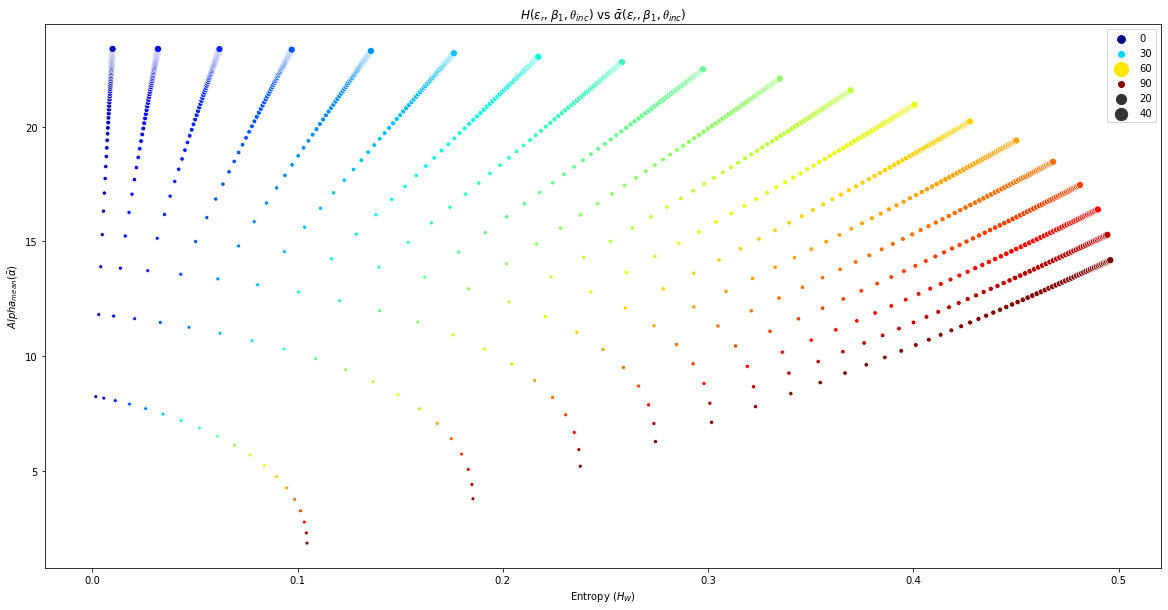

In [4]:
theta_inc = 45

x_epsilon = np.linspace(2,60,58)
y_beta = np.linspace(0, 90, 20)

X_epsilon,Y_beta = np.meshgrid(x_epsilon, y_beta)

XBrag_Model = XBragg(theta_inc=np.deg2rad(theta_inc), Epsilon_r=x_epsilon, Beta1=np.deg2rad(y_beta))

# XBrag_Model.XBraggModel(theta_inc=theta_inc, Epsilon_r=x_epsilon, Beta1=y_beta)
# plt.imshow(XBrag_Model.H)
fig, ax = plt.subplots(figsize=(20,10))

g = sns.scatterplot(palette="jet",x=XBrag_Model.H.flatten(), y=np.rad2deg(XBrag_Model.alpha_mean.flatten()), hue=Y_beta.flatten(order='C'), #  size=X_epsilon.flatten(order='F') #, marker=".",
                    size=X_epsilon.flatten(order='C'), marker=".", sizes=(60, 200)
                   )

#g.legend_.set_title("$β_1^°$")
g.set_title("$H(ε_𝑟, β_1, 𝜃_{inc})$ vs $\\bar{\\alpha}(ε_𝑟, β_1, 𝜃_{inc})} $")
g.set_xlabel("Entropy ($H_W$)")
g.set_ylabel("$Alpha_{mean} (\\bar{α})$")
leg = g.get_legend_handles_labels()[0]
leg.append

handles, labels = g.get_legend_handles_labels()
for h in handles[:]:
    sizes = [s / 10 for s in h.get_sizes()]
    h.set_sizes(sizes)
    #h.set_title(12)
    #print(la)

In [5]:
theta_inc = np.linspace(0, 90, 5)

palette = sns.color_palette("hls", len(theta_inc))
from collections import OrderedDict
cmaps = OrderedDict()
cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
cmaps.items()

odict_items([('Sequential', ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])])

/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in multiply
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


,H,A,Alpha_mean,Theta,Beta,Epsilon
0,NaN,NaN,0.000000e+00,0.0,0.0,2.000000
1,NaN,NaN,0.000000e+00,0.0,0.0,3.487179
2,NaN,NaN,0.000000e+00,0.0,0.0,4.974359
3,NaN,NaN,0.000000e+00,0.0,0.0,6.461538
4,NaN,1.0,5.920764e-49,0.0,0.0,7.948718


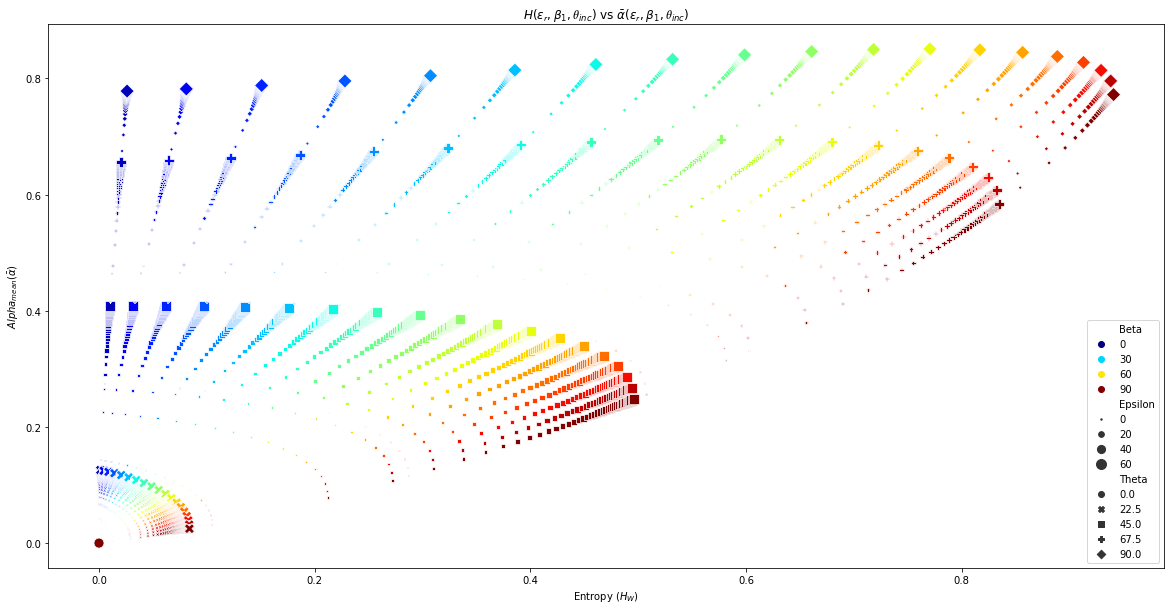

In [6]:
theta_inc = np.linspace(0, 90, 5)
x_epsilon = np.linspace(2, 60, 40)
y_beta = np.linspace(0, 90, 20)
X_epsilon, Y_beta = np.meshgrid(x_epsilon, y_beta)
df = pd.DataFrame(columns=['H','A','Alpha_mean', "Theta", "Beta", "Epsilon"])

appended_data = []

for i, cmap_list  in zip(range(len(theta_inc)), cmaps['Sequential']):
    XBrag_Model = XBragg(theta_inc=np.deg2rad(theta_inc[i]), Epsilon_r=x_epsilon, Beta1=np.deg2rad(y_beta))

    df_temp = pd.DataFrame(columns=['H','A','Alpha_mean', "Theta", "Beta", "Epsilon"])
    df_temp["H"] = XBrag_Model.H.flatten()
    df_temp["A"] = XBrag_Model.A.flatten()
    df_temp["Theta"] = theta_inc[i]
    df_temp["Alpha_mean"] = XBrag_Model.alpha_mean.flatten()
    df_temp["Epsilon"] = X_epsilon.flatten(order='C')
    df_temp["Beta"] = Y_beta.flatten(order='C')
    # print(df_temp.head())
    df.append(df_temp)
    appended_data.append(df_temp)


# see pd.concat documentation for more info
df = pd.concat(appended_data)
fig, ax = plt.subplots(figsize=(20,10))
g = sns.scatterplot(data=df, x="H", y="Alpha_mean", hue="Beta", size="Epsilon", style="Theta", palette="jet", sizes=(2, 100))
g.set_title("$H(ε_𝑟, β_1, 𝜃_{inc})$ vs $\\bar{\\alpha}(ε_𝑟, β_1, 𝜃_{inc})} $")
g.set_xlabel("Entropy ($H_W$)")
g.set_ylabel("$Alpha_{mean} (\\bar{α})$")
df.head()

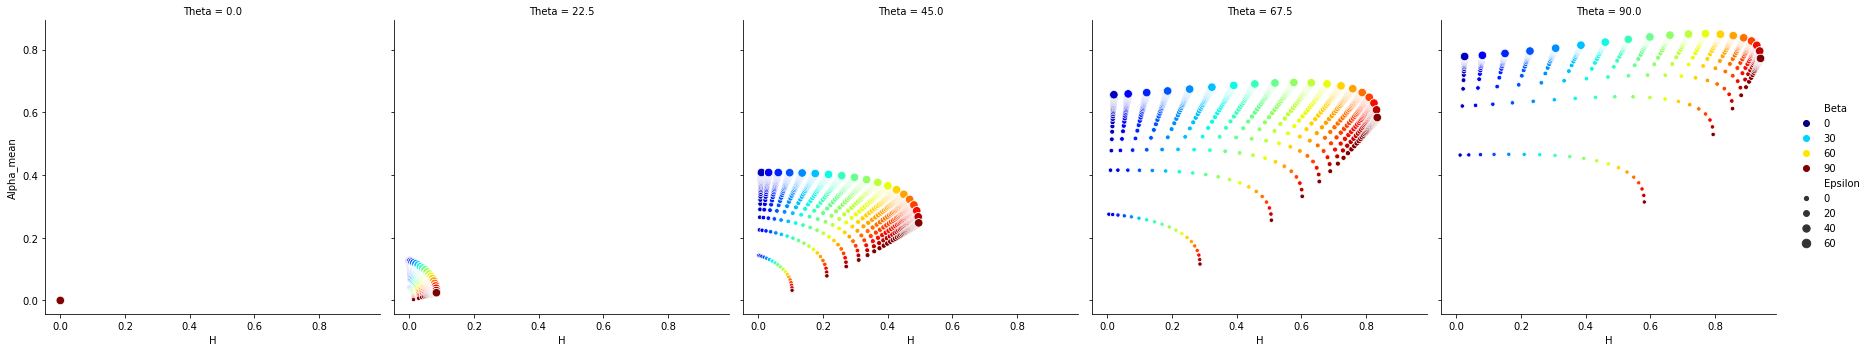

In [7]:
sns.relplot(data=df, x="H", y="Alpha_mean", hue="Beta", size="Epsilon",  col="Theta", palette="jet")


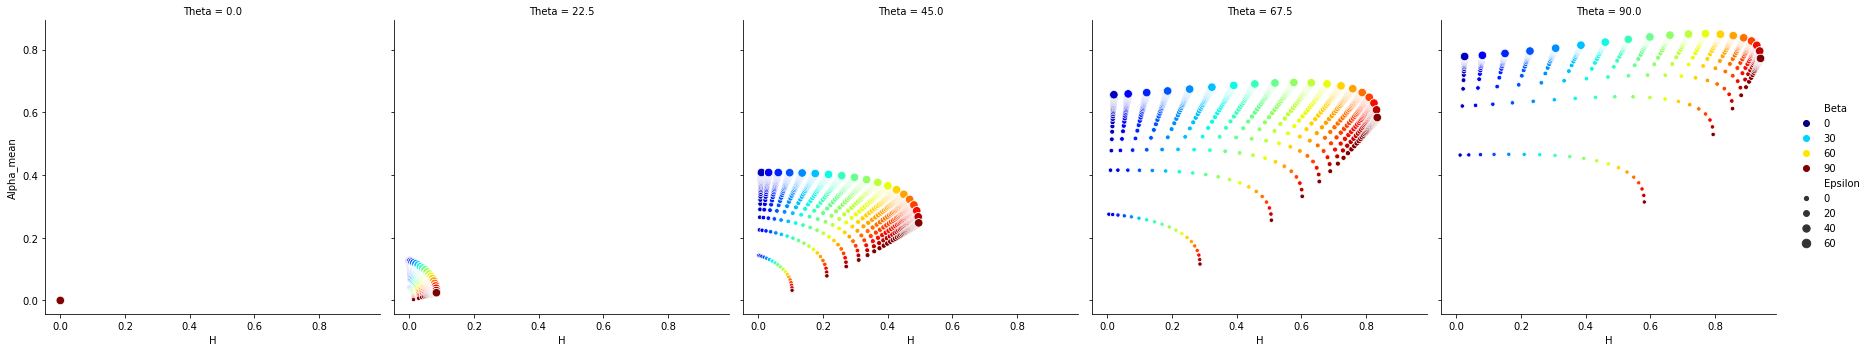

In [8]:
sns.relplot(data=df, x="H", y="Alpha_mean", hue="Beta", size="Epsilon", col="Theta", palette="jet")


/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in log
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in multiply
/home/mans_is/.local/apps/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


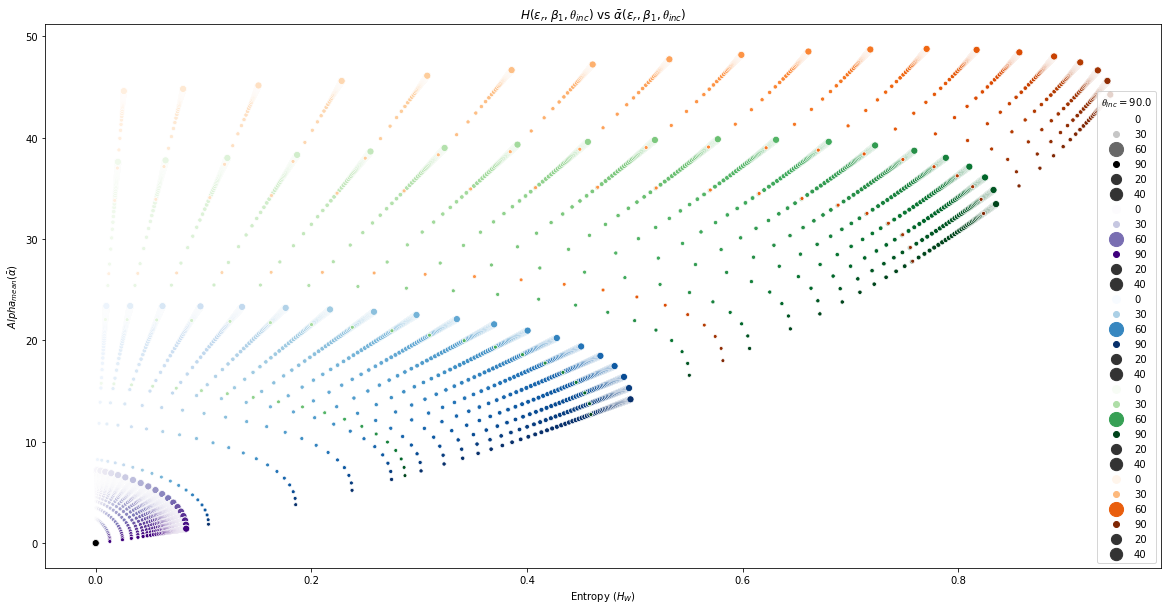

In [9]:
theta_inc = np.linspace(0, 90, 5)

fig, ax = plt.subplots(figsize=(20,10))
# palette = itertools.cycle(sns.color_palette())

palette_unique = sns.color_palette("hls", len(theta_inc))
# ax, name in zip(axes, cmap_list)
for i, cmap_list  in zip(range(len(theta_inc)), cmaps['Sequential']):
    x_epsilon = np.linspace(2, 60, 58)
    y_beta = np.linspace(0, 90, 20)

    X_epsilon,Y_beta = np.meshgrid(x_epsilon, y_beta)

    XBrag_Model = XBragg(theta_inc=np.deg2rad(theta_inc[i]), Epsilon_r=x_epsilon, Beta1=np.deg2rad(y_beta))

    # XBrag_Model.XBraggModel(theta_inc=theta_inc, Epsilon_r=x_epsilon, Beta1=y_beta)
    # plt.imshow(XBrag_Model.H)

    g = sns.scatterplot(palette=cmap_list, x=XBrag_Model.H.flatten(), y=np.rad2deg(XBrag_Model.alpha_mean.flatten()), hue=Y_beta.flatten(order='C'), #  size=X_epsilon.flatten(order='F') #, marker=".",
                        size=X_epsilon.flatten(order='C'), marker=".", sizes=(60, 200)
                       )
    g.legend_.set_title("$ 𝜃_{inc} = {%s}$"% theta_inc[i])

#g.legend_.set_title("$β_1^°$")
g.set_title("$H(ε_𝑟, β_1, 𝜃_{inc})$ vs $\\bar{\\alpha}(ε_𝑟, β_1, 𝜃_{inc})} $")
g.set_xlabel("Entropy ($H_W$)")
g.set_ylabel("$Alpha_{mean} (\\bar{α})$")
leg = g.get_legend_handles_labels()[0]
leg.append

handles, labels = g.get_legend_handles_labels()
for h in handles[:]:
    sizes = [s / 10 for s in h.get_sizes()]
    h.set_sizes(sizes)
    #h.set_title(12)
    #print(la)

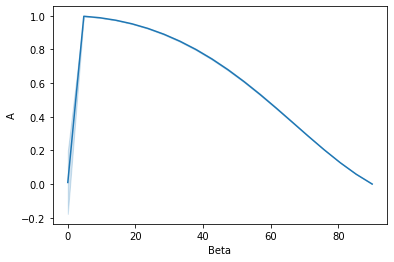

In [10]:
sns.lineplot(data=df, x="Beta", y="A")


For the soil roughness estimation, ks can be calculated by Equation: 

$ ks = 1 − A$ 

The volume water content of soil m v can be calculated from the relationship between $ε_r$ and $m_v$ :

$ m_v = 4.3 ∗ 10^{-6} ε_r^3  - 5.5 ∗ 10^{-4} ε_r^2 + 2.92 ∗ 10^{-2} ε_r - 5.3 ∗ 10^{-2} $ 

(3)
The effective range of the inversion model for estimating surface parameters is $m_v ≤ 35 \%$, $ks ≤ 2.5$
and $θ ≥ 30^◦ $.

In [17]:
1e-6*5

4.9999999999999996e-06

In [20]:
df["m_v"] = 4.3 * 10**-6 * df["Epsilon"]**3 - 5.5* 10**-4 * df["Epsilon"]**2 + 2.92 * 10**-2 * df["Epsilon"] - 5.3 * 10**-2

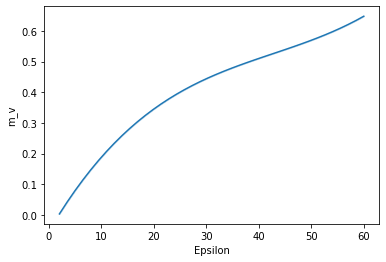

In [21]:
sns.lineplot(data=df, x="Epsilon", y="m_v")
